<a href="https://colab.research.google.com/github/deekshakoul/Sentence-classification-via-Attention-mechanism/blob/main/Attn_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-- Pictorial representation of how to have a simple attention mechanism applied to text-classification --


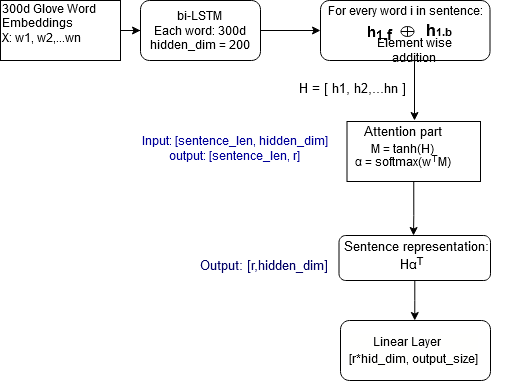

In [ ]:
!git clone https://github.com/deekshakoul/sent-conv-torch.git

Cloning into 'sent-conv-torch'...
remote: Enumerating objects: 477, done.
remote: Total 477 (delta 0), reused 0 (delta 0), pack-reused 477
Receiving objects: 100% (477/477), 58.85 MiB | 33.65 MiB/s, done.
Resolving deltas: 100% (309/309), done.


In [ ]:
import re,string
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split

import os
import copy
#=========================pytorch========================#
import torch   
from torchtext import data ,vocab
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
SEED = 134
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print("cuda? ",torch.cuda.is_available())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
cuda?  True


In [ ]:
def clean_str(string):
  string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
  string = re.sub(r"\'s", " \'s", string) 
  string = re.sub(r"\'ve", " \'ve", string) 
  string = re.sub(r"n\'t", " n\'t", string) 
  string = re.sub(r"\'re", " \'re", string) 
  string = re.sub(r"\'d", " \'d", string) 
  string = re.sub(r"\'ll", " \'ll", string) 
  string = re.sub(r",", " , ", string) 
  string = re.sub(r"!", " ! ", string) 
  string = re.sub(r"\(", " ( ", string) 
  string = re.sub(r"\)", " ) ", string) 
  string = re.sub(r"\?", " ? ", string) 
  string = re.sub(r"\s{2,}", " ", string)    
  return string.strip().lower()

def create_df(filename):
  with open(filename,'rb') as f: #MR
    q = f.readlines()
  texts=[]
  for i in range(len(q)):
    # print(i)
    texts.append(q[i].decode('latin-1'))
  ###################create dataframe##########################
  df = pd.DataFrame(texts, columns=['text'])
  df['label'] = df['text']
  df['label'] =df['label'].apply(lambda s: s.split(" ")[0])
  df['text']=df['text'].apply(lambda s: s[1:])
  df['label'] = df['label'].astype(int)
  return df  

In [ ]:
data_p = "/content/sent-conv-torch/data/"
def create_alldata_csv(fname):
  ''' 
      Read from file
      create dataframe, appply pre-processing from RP
      save all data to csv 
  '''
  path=os.path.join(data_p,fname)
  print(path)
  df = create_df(path)
  df['text'] = df['text'].apply(clean_str)

  #remove zero length texts
  ll = list(df["text"].apply(lambda s: len(s)))
  inds = [ i for i in range(len(ll)) if ll[i]==0]
  df = df.drop(index=inds)
  df.to_csv("fulldata.csv",index=False)
  return df

In [ ]:
df = create_alldata_csv('rt-polarity.all') 
#subj.all , custrev.all , rt-polarity.all , mpqa.all
df=df.sample(frac=1)

/content/sent-conv-torch/data/rt-polarity.all


In [ ]:
!head "fulldata.csv"

In [ ]:
TEXT = data.Field(lower=True,batch_first=True,include_lengths=True)#,stop_words=stop), tokenize='spacy',
LABEL = data.LabelField(dtype = torch.int,batch_first=True)
fields = [('text',TEXT),('label', LABEL)]
all_data = data.TabularDataset(skip_header = True,path='/content/fulldata.csv',format = 'csv', fields=fields)
#print(vars(valid_data.examples[190]))

In [ ]:
######################Dont run again and again###########################
!cp /content/drive/My\ Drive/datasets/glove.840B.300d.zip /content
!unzip /content/glove.840B.300d.zip
import os
emb_path = '/content'
vec = vocab.Vectors(os.path.join(emb_path, 'glove.840B.300d.txt'), cache=emb_path,unk_init = torch.Tensor.normal_)
#unk_init (callback): by default, initialize out-of-vocabulary word vectors to zero vectors;

Archive:  /content/glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


100%|█████████▉| 2195759/2196017 [04:01<00:00, 9514.32it/s]

In [ ]:
TEXT.build_vocab(all_data,vectors = vec ) #all_data has tokens(words) and they will be mapped to embeddings of glove..if word is in glove
LABEL.build_vocab(all_data)
word_embeddings = TEXT.vocab.vectors
word_embeddings[1] = torch.zeros(word_embeddings.shape[1])
print("Size of TEXT vocabulary:",len(TEXT.vocab)) #total words
print("===========\n",TEXT.vocab.vectors)
#u will notice <UNK>:0 and <PAD>:1 initialized randomly.....rest words or indices will always remain same

Size of TEXT vocabulary: 18767
 tensor([[-0.0915, -1.2666,  0.8834,  ...,  0.3752, -1.2412, -1.3260],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [-0.0029, -0.4766, -0.1945,  ..., -0.0704,  0.6770,  0.4400],
        [ 0.1710,  0.2598, -0.4678,  ...,  0.0272, -0.0048, -0.1162],
        [ 0.8430, -0.0559, -0.0837,  ...,  0.9208, -0.2708, -0.4322]])


In [ ]:
print(TEXT.vocab.stoi)
dd = TEXT.vocab.stoi

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
cv = 10
kf = StratifiedKFold(cv, True, SEED)

folds=[]
for tr, tt in kf.split(df["text"], df["label"]):
    #print(train_index, test_index)
    #print(len(train_index), len(test_index))
    folds.append((list(tr), list(tt)))

In [ ]:
global testing
testing =  False
global attn_wts_test;
clip=1e-3
batch = 16
EPOCHS = 200
'''lrate = 0.2e-5
wd =3e-6'''
lrate = 0.5e-5
wd =1e-6
parms=[clip,batch,EPOCHS,lrate,wd]
#wd is generally higher than lr
#a higher lr will be bad
fold_scores = []
# test_loss = []
test_loss_fold=[]
tr_loss_fold=[]
flag=True
ffd=0
best_acc_overall =0
for i, (tr_ix, tt_ix) in enumerate(folds):
  print("Fold ==> ",i+1)
  train_data = [item for i,item in enumerate(all_data) if i in tr_ix]
  test_data = [item for i,item in enumerate(all_data) if i in tt_ix]
  train = data.Dataset(train_data,fields)
  test = data.Dataset(test_data,fields)
  print("train size: ", len(train_data), " and test size: ", len(test_data))
  print("how many training ex.s skipped ",divmod(len(train_data),batch)[1],"how many test ex.s skipped ",divmod(len(test_data),batch)[1])
  train_itr, test_itr  = data.BucketIterator.splits(
                (train, test), 
                batch_size = batch,
                sort_key = lambda x: len(x.text),
                sort_within_batch=True,
                device = device,
                shuffle=True
              )   
  model = build_model(word_embeddings) #initilize mlodel object along with pretrained embeddings
  print(f'The model has {count_parameters(model):,} trainable parameters')
  
  #################WEIGHT INITIALIZATION###########################
  model.apply(weights_init_N)
  model.embedding.weight.data.copy_(word_embeddings) #vocab x embed_dim
  model.embedding.weight.data[1] = torch.zeros(300)
  
  criterion = build_criterion()
  
  optimizer = torch.optim.Adam(model.parameters(),lr=lrate, weight_decay=wd) # some of the parameters you give the optimizer do not require gradients, and so he don’t know how to handle them

  best_acc = 0.0
  best_loss = 100.0
  test_loss = []
  tr_loss = []
  test_acc = []
  tr_acc = []
  for ep in range(EPOCHS):
    train_loss, train_acc = training(model,train_itr,criterion,batch, optimizer,clip=clip)
    eval_loss, eval_acc = evaluation(model,test_itr,batch)
    print(f'Epoch: {ep+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f} %, Test Loss: {eval_loss:3f}, test Acc: {eval_acc:.2f}%')
    test_loss.append(eval_loss)
    tr_loss.append(train_loss)
    test_acc.append(eval_acc)
    tr_acc.append(train_acc)
    if eval_acc > best_acc:
      best_acc = eval_acc
      best_acc_ep = ep
      best_acc_loss = eval_loss
      ffd=i
    if eval_loss < best_loss:
      best_loss = eval_loss
      best_loss_ep = ep
      best_loss_acc = eval_acc

  if  best_acc_overall < best_acc:  #best_acc is for every fold
    best_acc_overall = best_acc
    model_copy = copy.deepcopy(model)
    print("For fold ",i+1," given ",cv," folds", " best accuracy for this fold is  ",best_acc)


  plot_losses_per_fold(tr_loss,test_loss,i+1)
  plot_losses_per_fold(tr_acc,test_acc,i+1,"ACC")

  fold_scores.append((i,best_acc_ep,best_acc,best_acc_loss,i,best_loss_ep,best_loss,best_loss_acc))

parms.extend([best_acc_ep,best_acc,best_acc_loss,ffd])

#the model with max accuarcy OVER all folds is stored

model_params(parms)
print(dfp)

In [ ]:
best_acc_overall

80.42664670658682

In [ ]:
def plot_losses_per_fold(tr, tt,fold,c="LOSS"):
  epoch_count = range(1, len(tr) + 1)
  name = 'MR' + "_CV" + str(fold)  + "_" + c
  plt.plot(epoch_count, tr, 'r--')
  plt.plot(epoch_count, tt, 'b-')
  if c == "LOSS":
    plt.legend(['Training Loss', 'Test Loss'])
  else:
    plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss') 
  if c=="ACC":
    plt.ylabel('Accuracy') 
  
  plt.xticks(np.arange(min(epoch_count), max(epoch_count)+1, 40.0))
  # plt.ylim(-5, 5)
  plt.savefig(name)
  plt.close()

In [ ]:
acc_folds = [fold_scores[i][2] for i in range(len(fold_scores))]
mean_acc = sum(acc_folds)/len(fold_scores)
print(mean_acc)
acc_folds = [fold_scores[i][2] for i in range(len(fold_scores))]
print(acc_folds)

---TESTING----

In [ ]:
dd = TEXT.vocab.stoi
k = list(dd.keys())
v = list(dd.values())
def get_sent(text):
  sent=[]  
  for i in text:
    sent.append(k[v.index(i)])
  return sent
def get_indices_sent(text):
  ind=[]
  tokens = text.split()
  for i in range(len(tokens)):  
    if tokens[i] in k:
      ind.append(dd[tokens[i]])
    else:
      ind.append(TEXT.vocab.stoi[TEXT.unk_token])
  return ind      

In [ ]:
# sentences = ["interesting , but not compelling", "good movie good  music", "loved the script ", 'loved the movie', 'loving script','silly movie']
sentences = ["light , cute and forgettable"]
##"interesting , but not compelling"

#sentences = [ "what is the percentage of water in human body" , "what articles of clothing are tokens in monopoly"]#TREC

In [ ]:
txt, txt_len = make_batch(sentences)
testing = True
sts = len(sentences)
model_copy.eval()
with torch.no_grad():
  if torch.cuda.is_available():
    txt = txt.cuda()
    txt_len = txt_len.cuda()
  predictions = model_copy(txt, txt_len)
  print(predictions)
  print(torch.max(predictions, 1)[1].view(sts).data,"\n \n")

In [ ]:
# global testing
attn_wts_test.size()#[batch, r, words]
attns = attn_wts_test.permute(0,2,1)
attns

tensor([[[0.0527],
         [0.0624],
         [0.1439],
         [0.1679],
         [0.5731]]], device='cuda:0')

In [ ]:
def make_batch(sent):
  l=[]
  m=[]
  max = 0
  for i in range(len(sent)):
    ind = get_indices_sent(clean_str(sent[i]))
    l.append(ind)
    if len(ind)>max:
      max=len(ind)
    m.append(len(ind))

  for i in range(len(l)):
    length_sent = len(l[i])
    if length_sent != max:
      l[i].extend([TEXT.vocab.stoi[TEXT.pad_token]]*(max - length_sent))
  # print(torch.LongTensor(l).size(),"=====",torch.LongTensor(m).size())
  # print(torch.LongTensor(l),"=====",torch.LongTensor(m))
  return torch.LongTensor(l), torch.LongTensor(m)

---TESTING END---

In [ ]:
params = ['clip', 'batch', 'EPOCHS', 'lrate', 'wd', 
          'hid_dim','dropout_lstm','nlayers-lstm','bilstm','r', 'dropout_m1','#parameters',
          'Epoch of best acc','best acc','best acc-loss','which fold']
dfp = pd.DataFrame(columns=params)
  
def model_params(arr):
  global dfp
  dfp.loc[len(dfp)] = arr  

In [ ]:
def build_criterion(): 
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)
  return criterion

def build_model(word_embeddings):
  vocab_dim = len(TEXT.vocab)
  global flag;
  embed_dim = 300
  hid_dim= 300
  dropout_lstm = 0.5
  nlstm=2
  SRC_PAD_IDX=TEXT.vocab.stoi[TEXT.pad_token]
  bidirectional=True
  intermediate_val_r = 1
  dropout_m1 = 0.5
  output_size = 2
  model = MainNetwork(vocab_dim, embed_dim,word_embeddings,SRC_PAD_IDX, hid_dim,dropout_lstm,nlstm, bidirectional,intermediate_val_r,dropout_m1,output_size)
  #model.apply(initialize_weights);
  #model.embedding.weight.data.copy_(word_embeddings)
  model = model.to(device)
  if flag == True:
    parms.extend([hid_dim,dropout_lstm,nlstm,bidirectional,intermediate_val_r,dropout_m1,count_parameters(model)])
    flag=False

  return model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
#############WEIGHT INITIALIZATION###############

def weights_init_XU(m):
  if hasattr(m, 'weight') and m.weight.dim() > 1:
    nn.init.xavier_uniform_(m.weight.data)

def weights_init_N(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1)
        #nn.init.normal_(m.weight.data)

def weights_init_XN(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_normal_(m.weight.data)

=== MAIN MODEL ===

Insipiration from NMT model by Bahadanau

In [ ]:
# [batch , text]
class MainNetwork(nn.Module):
  def __init__(self,vocab_dim, embed_dim,weights,SRC_PAD_IDX, hid_dim,dropout_lstm,nlstm, bidirectional,intermediate_val_r,dropout_m1,output_size):
    super(MainNetwork,self).__init__();  
    self.r = intermediate_val_r
    self.hid_dim = hid_dim
    self.dir = 2 if bidirectional else 1
    self.embedding = nn.Embedding.from_pretrained(word_embeddings,padding_idx= SRC_PAD_IDX,freeze=True)
    #print("########WORD EMBEDS##########\n", self.embedding.weight.data,"\n @@@@@@@@@@@@@")
    self.lstm = nn.LSTM(embed_dim, hid_dim,
                        batch_first=True,
                        dropout = 0 if nlstm < 2 else dropout_lstm,
                        num_layers=nlstm,
                        bidirectional=bidirectional);
    ##--------For attention--------##
    #self.W_l1 = nn.Linear(hid_dim, 350)
    self.W_s2 = nn.Linear(hid_dim, self.r, bias=True) #r=1
    self.fc_layer = nn.Linear(self.r*hid_dim, output_size)
    #self.label = nn.Linear(2000, output_size) --> dont think needed
    self.dropout = nn.Dropout(dropout_m1)


  def attn_wt_matrix(self, lstm_out):
    wM = self.W_s2(F.tanh(lstm_out))  #now output is  batch,seq_len, r, torch.nn.Tanh
    wM = wM.permute(0, 2, 1) 
    attn_wts = F.softmax(wM, dim=2)
    return attn_wts

  def forward(self, text,text_lengths): # [batch, max_sent_len]  
    global testing;
    global attn_wts_test;
    b = text.shape[0]
    seq_len = text.shape[1]
    embeds = self.dropout(self.embedding(text)) #[batch, max_len, embed_size]
    embeds_packed = nn.utils.rnn.pack_padded_sequence(embeds, text_lengths, batch_first=True)
    
    # if batch_size is None:
		# 	h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
		# 	c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
		# else:
    h_0 = Variable(torch.zeros(2*2, b, self.hid_dim).cuda())
    c_0 = Variable(torch.zeros(2*2, b, self.hid_dim).cuda())
    
    packed_out, (fh,fc) = self.lstm(embeds_packed,(h_0, c_0)) #[batch, max_len, hid_dim*2] ; hid_dim of lstm bec bi
    #from the last layer of the LSTM
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_out)
    #The elements of output from padding tokens will be zero tensors (tensors where every element is zero)
    output = output.permute(1,0,2)
    output = output.view(b, seq_len, self.dir, self.hid_dim) 
    output = torch.sum(output, dim=2) #element-wise sum to combine theforward and backward pass outputs - See RP --> our H
    attn_wts = self.attn_wt_matrix(output) #mentioned as ALPHA in RP
    hidden_matrix = self.dropout(torch.bmm(attn_wts, output))

    #FLATTEN OUT
    fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2])) #bec input to FC layer is r*hid_dim, output will be [batch, output_size]

    if testing:
      attn_wts_test = attn_wts#[batch, r, seq_len]
      
    return fc_out

In [ ]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

In [ ]:
def training(model, iterator, criterion, batch_size,optimizer,clip):
  # print("training ")
  epoch_loss = 0.0
  epoch_accuracy = 0.0
 
  model.train()
  for batch in iterator:
    texts,text_lengths = batch.text 
    target = batch.label.type(torch.LongTensor)
    #print("TEXT SHAPE", texts.shape,"***", text_lengths)#torch.Size([40, 9]) number, max_length

    if  texts.shape[0]!=batch_size:
      continue;

    if torch.cuda.is_available():
      texts = texts.cuda()
      target = target.cuda()    

    optimizer.zero_grad() 
    
    predictions_batch  =  model(texts, text_lengths) #[batch, output_size]
    loss = criterion(predictions_batch, target)
    num_corrects = (torch.max(predictions_batch, 1)[1].view(target.size()).data == target.data).float().sum()
    acc = 100.0 * num_corrects/len(batch)

    loss.backward()    
    clip_gradient(model,clip)   
    
    optimizer.step()   
    
    #loss and accuracy
    epoch_loss += loss.item()  
    epoch_accuracy += acc.item()     
    
  return epoch_loss / len(iterator), epoch_accuracy / len(iterator)  

In [ ]:
def evaluation(model, iterator, batch_size):
    total_epoch_loss = 0
    total_epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            text, text_lengths = batch.text

            target = batch.label.type(torch.LongTensor)
            if  text.shape[0]!=batch_size:
              continue;
            if torch.cuda.is_available():
              text = text.cuda()
              target = target.cuda()    

            predictions = model(text, text_lengths)
            loss = criterion(predictions, target)
            num_corrects = (torch.max(predictions, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            
    return total_epoch_loss/len(iterator), total_epoch_acc/len(iterator)
